In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import os
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F

In [ ]:
data = pd.read_csv(r"/content/weatherAUS.csv")

In [ ]:
data.shape  

(145460, 23)

In [ ]:
data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [ ]:
col = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']
data = data[col]

In [ ]:
data['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
data['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
data = data.dropna(how='any')

In [ ]:
data.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0.0
1,0.0,25.0,1010.6,0.0,0.0
2,0.0,30.0,1007.6,0.0,0.0
3,0.0,16.0,1017.6,0.0,0.0
4,1.0,33.0,1010.8,0.0,0.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


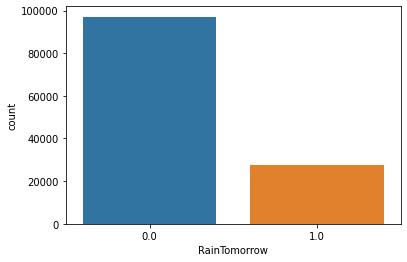

In [ ]:
sns.countplot(data.RainTomorrow);

In [ ]:
data.RainTomorrow.value_counts() / data.shape[0]

0.0    0.778762
1.0    0.221238
Name: RainTomorrow, dtype: float64

In [ ]:
X = data[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
Y = data[['RainTomorrow']]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = None)

In [ ]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
Y_train = torch.squeeze(torch.from_numpy(Y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
Y_test = torch.squeeze(torch.from_numpy(Y_test.to_numpy()).float())

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


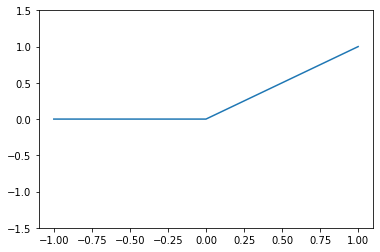

In [ ]:
ax = plt.gca()

plt.plot(
  np.linspace(-1, 1, 5), 
  F.relu(torch.linspace(-1, 1, steps=5)).numpy()
)
ax.set_ylim([-1.5, 1.5]);

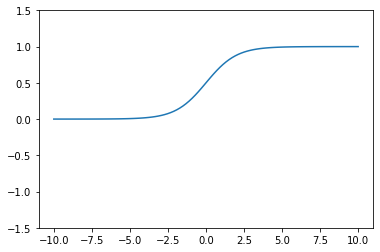

In [ ]:
ax = plt.gca()

plt.plot(
  np.linspace(-10, 10, 100), 
  torch.sigmoid(torch.linspace(-10, 10, steps=100)).numpy()
)
ax.set_ylim([-1.5, 1.5]);

In [ ]:
criterion = nn.BCELoss()

In [ ]:
def ann_viz(model, view=True, filename="network.gv"):
       from graphviz import Digraph

    input_layer = 0
    hidden_layers_nr = 0
    layer_types = []
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    for layer in layers:
        if layer == layers[0]:
            input_layer = layer.in_features
            hidden_layers_nr += 1
            if type(layer) == torch.nn.Linear:                
                hidden_layers.append(layer.out_features)
                layer_types.append("Dense")
            else:
                raise Exception("Input error")

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers_nr += 1
                if type(layer) == torch.nn.Linear:

                    hidden_layers.append(layer.out_features)
                    layer_types.append("Dense")
                else:
                    raise Exception("Hidden error")
        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename=filename)
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
        if type(layers[0]) == torch.nn.Linear:
            the_label = "Input Layer"
            if layers[0].in_features > 10:
                the_label += " (+" + str(layers[0].in_features - 10) + ")"
                input_layer = 10
            c.attr(color="white")
            for i in range(0, input_layer):
                n += 1
                c.node(str(n))
                c.attr(labeljust="1")
                c.attr(label=the_label, labelloc="bottom")
                c.attr(rank="same")                
                c.node_attr.update(
                    width="0.65",
                    style="filled",                    
                    shape="circle",
                    color=HAPPY_COLORS_PALETTE[3],
                    fontcolor=HAPPY_COLORS_PALETTE[3],
                )
    for i in range(0, hidden_layers_nr):
        with g.subgraph(name="cluster_" + str(i + 1)) as c:
            if layer_types[i] == "Dense":
                c.attr(color="white")
                c.attr(rank="same")
                the_label = f'Hidden Layer {i + 1}'
                if layers[i].out_features > 10:
                    the_label += " (+" + str(layers[i].out_features - 10) + ")"
                    hidden_layers[i] = 10
                c.attr(labeljust="right", labelloc="b", label=the_label)
                for j in range(0, hidden_layers[i]):
                    n += 1
                    c.node(
                        str(n),
                        width="0.65",
                        shape="circle",
                        style="filled",
                        color=HAPPY_COLORS_PALETTE[0],
                        fontcolor=HAPPY_COLORS_PALETTE[0],
                    )
                    for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                        g.edge(str(h), str(n))
                last_layer_nodes = hidden_layers[i]
                nodes_up += hidden_layers[i]
            else:
                raise Exception("Hidden layer type not supported")

    with g.subgraph(name="cluster_output") as c:
        if type(layers[-1]) == torch.nn.Linear:
            c.attr(color="white")
            c.attr(rank="same")
            c.attr(labeljust="1")
            for i in range(1, output_layer + 1):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[4],
                    fontcolor=HAPPY_COLORS_PALETTE[4],
                    
                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            c.attr(label="Output Layer", labelloc="bottom")
            c.node_attr.update(
                color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
            )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    if view is True:
        g.view()

    return g

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

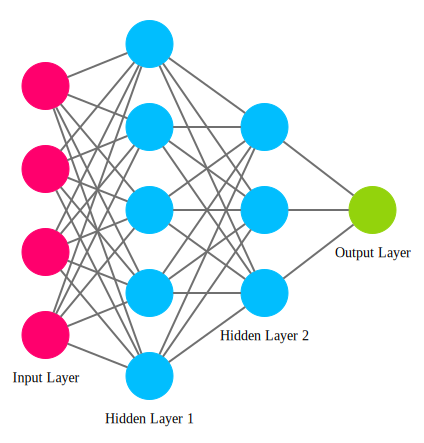

In [ ]:
net = Net(X_train.shape[1])

ann_viz(net, view=False)

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = Y_train.to(device)

X_test = X_test.to(device)
y_test = Y_test.to(device)
net = net.to(device)

criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)  

In [ ]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):
    
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, Y_train)
    
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(Y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(Y_test)

      test_loss = criterion(y_test_pred, Y_test)

      test_acc = calculate_accuracy(Y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

epoch 0
Train set - loss: 2.514, accuracy: 0.779
Test  set - loss: 0.0, accuracy: 1.0

epoch 100
Train set - loss: 0.457, accuracy: 0.793
Test  set - loss: 0.0, accuracy: 1.0

epoch 200
Train set - loss: 0.435, accuracy: 0.801
Test  set - loss: 0.0, accuracy: 1.0

epoch 300
Train set - loss: 0.421, accuracy: 0.814
Test  set - loss: 0.0, accuracy: 1.0

epoch 400
Train set - loss: 0.413, accuracy: 0.826
Test  set - loss: 0.0, accuracy: 1.0

epoch 500
Train set - loss: 0.408, accuracy: 0.832
Test  set - loss: 0.0, accuracy: 1.0

epoch 600
Train set - loss: 0.406, accuracy: 0.833
Test  set - loss: 0.0, accuracy: 1.0

epoch 700
Train set - loss: 0.405, accuracy: 0.834
Test  set - loss: 0.0, accuracy: 1.0

epoch 800
Train set - loss: 0.404, accuracy: 0.834
Test  set - loss: 0.0, accuracy: 1.0

epoch 900
Train set - loss: 0.404, accuracy: 0.835
Test  set - loss: 0.0, accuracy: 1.0



In [ ]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
Y_test = Y_test.cpu()

print(classification_report(Y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19426
     Raining       0.74      0.39      0.51      5512

    accuracy                           0.83     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.82      0.83      0.81     24938



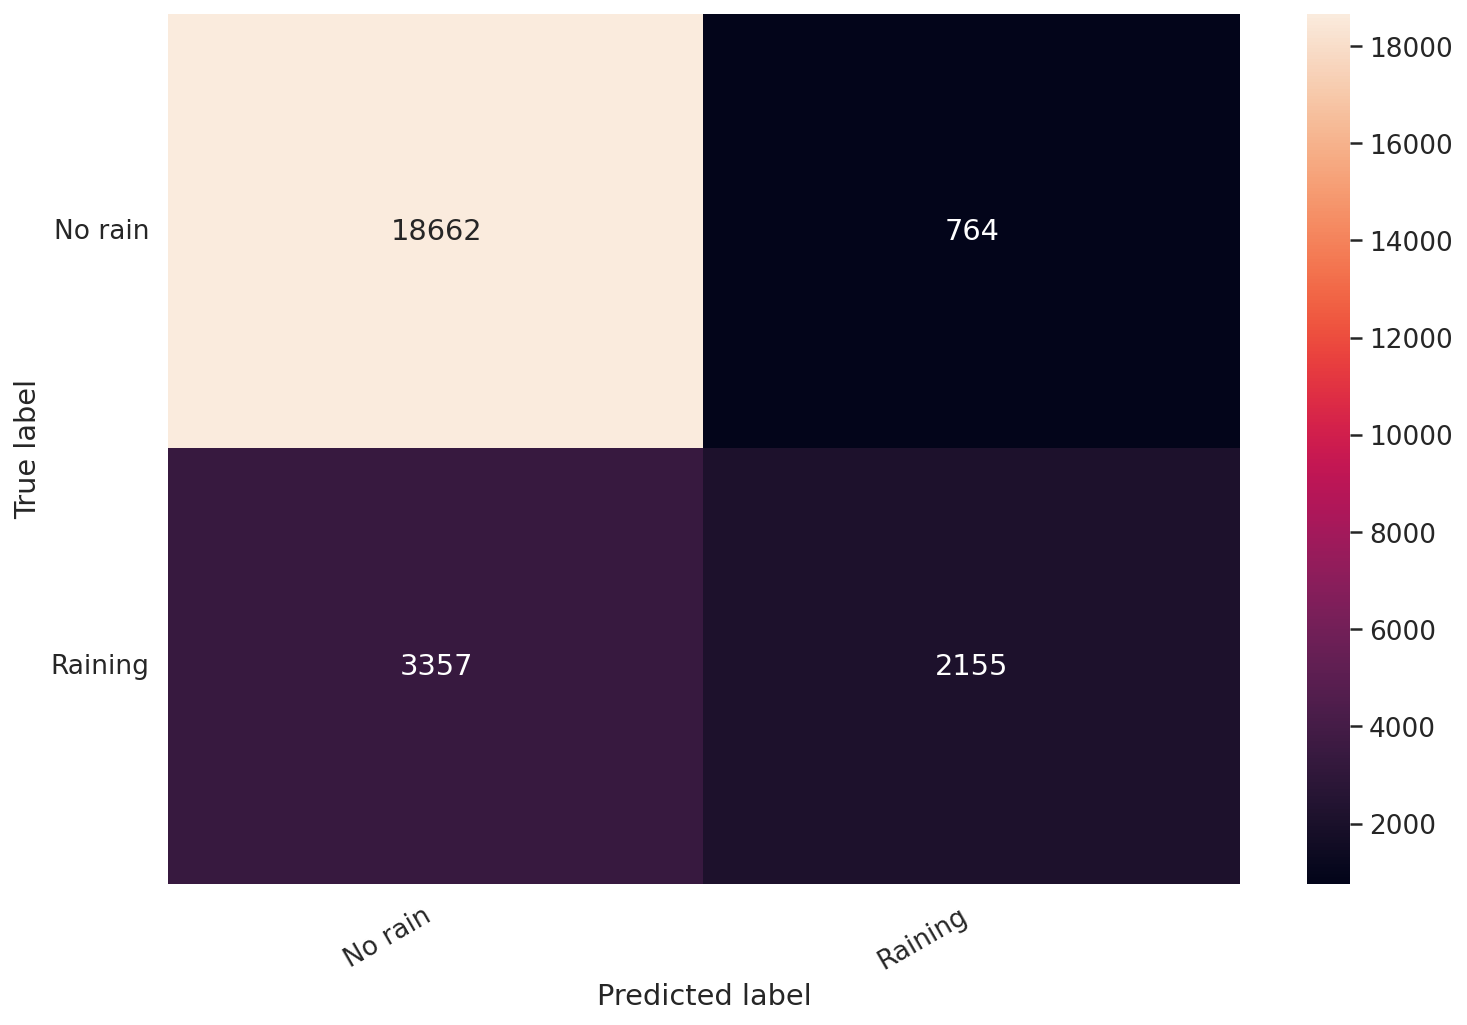

In [ ]:
cm = confusion_matrix(Y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');